<a href="https://colab.research.google.com/github/Ahaannarang/movie-profit-predictor/blob/main/Movie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [ ]:
# STEP 2 Load DATA
from google.colab import files
import pandas as pd

# Change later when moving to github
uploaded = files.upload()

# Load the core metadata file
movies = pd.read_csv("movies_metadata.csv", low_memory=False)

# Load extra files
keywords = pd.read_csv("keywords.csv")

print("Movies Metadata:")
display(movies.head(2))

print("\nKeywords:")
display(keywords.head(2))




Saving keywords.csv to keywords.csv
Saving movies_metadata.csv to movies_metadata.csv
Movies Metadata:


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0



Keywords:


,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."


In [ ]:
# Clean & attach keywords (final: keep only budget>0 & revenue not-NaN) =====
import ast
import numpy as np
import pandas as pd

# --- Helpers ---
def _to_num(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.replace(r"[^\d.]", "", regex=True)
    s = s.replace({"": np.nan, ".": np.nan})
    return pd.to_numeric(s, errors="coerce")

def _parse_keywords(cell):
    try:
        arr = ast.literal_eval(cell)
        if isinstance(arr, list):
            return [(d.get("name","") or "").strip().lower() for d in arr if isinstance(d, dict)]
    except Exception:
        pass
    return []

# 0) Safety: unique columns
movies   = movies.loc[:, ~movies.columns.duplicated()].copy()
keywords = keywords.loc[:, ~keywords.columns.duplicated()].copy()

# 1) Coerce money cols and apply STRICT filter (budget>0 & revenue not-NaN; revenue may be 0)
for col in ["budget", "revenue"]:
    if col in movies.columns:
        movies[col] = _to_num(movies[col])

before = len(movies)
movies = movies[(movies["budget"] > 0) & (movies["revenue"].notna())].copy()
print(f"[reset] kept {len(movies):,}/{before:,} rows (budget>0 & revenue not-NaN; revenue may be 0).")

# 2) TMDB numeric id join key
if "id_num" not in movies.columns:
    movies["id_num"] = pd.to_numeric(movies.get("id"), errors="coerce")

# 3) Attach keywords (coalesce movie keywords + CSV keywords; validate many-to-one)
src_col = None
if isinstance(keywords, pd.DataFrame) and (("id" in keywords.columns) or ("tmdbId" in keywords.columns)):
    kw = keywords.copy()
    keycol = "id" if "id" in kw.columns else "tmdbId"
    kw["id_num"] = pd.to_numeric(kw[keycol], errors="coerce")
    kw = kw[["id_num", "keywords"]].dropna(subset=["id_num"]).drop_duplicates(subset=["id_num"])
    movies = movies.merge(kw, on="id_num", how="left", validate="many_to_one", suffixes=("", "_kw"))
    # Coalesce text columns into one 'keywords_merged'
    if "keywords" in movies.columns and "keywords_kw" in movies.columns:
        movies["keywords_merged"] = movies["keywords"].combine_first(movies["keywords_kw"])
        movies.drop(columns=["keywords_kw"], inplace=True)
    elif "keywords_kw" in movies.columns:
        movies.rename(columns={"keywords_kw": "keywords_merged"}, inplace=True)
    elif "keywords" in movies.columns:
        movies.rename(columns={"keywords": "keywords_merged"}, inplace=True)
    else:
        movies["keywords_merged"] = np.nan
    src_col = "keywords_merged"
elif "keywords" in movies.columns:
    movies.rename(columns={"keywords": "keywords_merged"}, inplace=True)
    src_col = "keywords_merged"

# Parse to kw_list
if src_col is not None:
    movies["kw_list"] = movies[src_col].apply(_parse_keywords)
else:
    movies["kw_list"] = [[] for _ in range(len(movies))]

# 4) Other fields needed later
movies["release_year"] = pd.to_datetime(movies.get("release_date"), errors="coerce").dt.year
movies["decade"]       = (movies["release_year"] // 10 * 10).astype("Int64")
if "popularity" not in movies.columns:
    movies["popularity"] = np.nan

# Target: binary 0/1 (no NaNs because revenue is non-null; can be 0)
movies["is_profitable"] = (movies["revenue"] > movies["budget"]).astype(int)

# 5) Build kw_df from this filtered set
_required = ["id_num", "release_year", "is_profitable", "popularity", "kw_list"]
_missing  = [c for c in _required if c not in movies.columns]
if _missing:
    raise KeyError(f"Missing columns for keyword clusters: {_missing}")

kw_df = movies[_required].dropna(subset=["release_year"]).copy()
print("kw_df shape:", kw_df.shape)


[reset] kept 8,890/45,466 rows (budget>0 & revenue not-NaN; revenue may be 0).
kw_df shape: (8886, 5)


In [ ]:
import ast

# Parse the first genre from the 'genres' JSON string
def _parse_first_genre(cell):
    try:
        arr = ast.literal_eval(cell)
        if isinstance(arr, list) and len(arr) > 0 and isinstance(arr[0], dict):
            return arr[0].get("name", "Unknown")
    except Exception:
        return "Unknown"
    return "Unknown"

if "main_genre" not in movies.columns:
    if "genres" in movies.columns:
        movies["main_genre"] = movies["genres"].apply(_parse_first_genre)
    else:
        movies["main_genre"] = "Unknown"

In [ ]:
#Inflation-adjusted budget/revenue
BASE_YEAR = 2017
ANNUAL_RATE = 0.03
yr = movies["release_year"].astype("Float64")
factor = np.power(1.0 + ANNUAL_RATE, BASE_YEAR - yr).fillna(1.0)

movies["budget_adj"]  = movies["budget"]  * factor
movies["revenue_adj"] = movies["revenue"] * factor

#Logs if needed
movies["log_budget"]       = np.log1p(movies["budget"])
movies["log_revenue"]      = np.log1p(movies["revenue"])
movies["log_budget_adj"]   = np.log1p(movies["budget_adj"])
movies["log_revenue_adj"]  = np.log1p(movies["revenue_adj"])

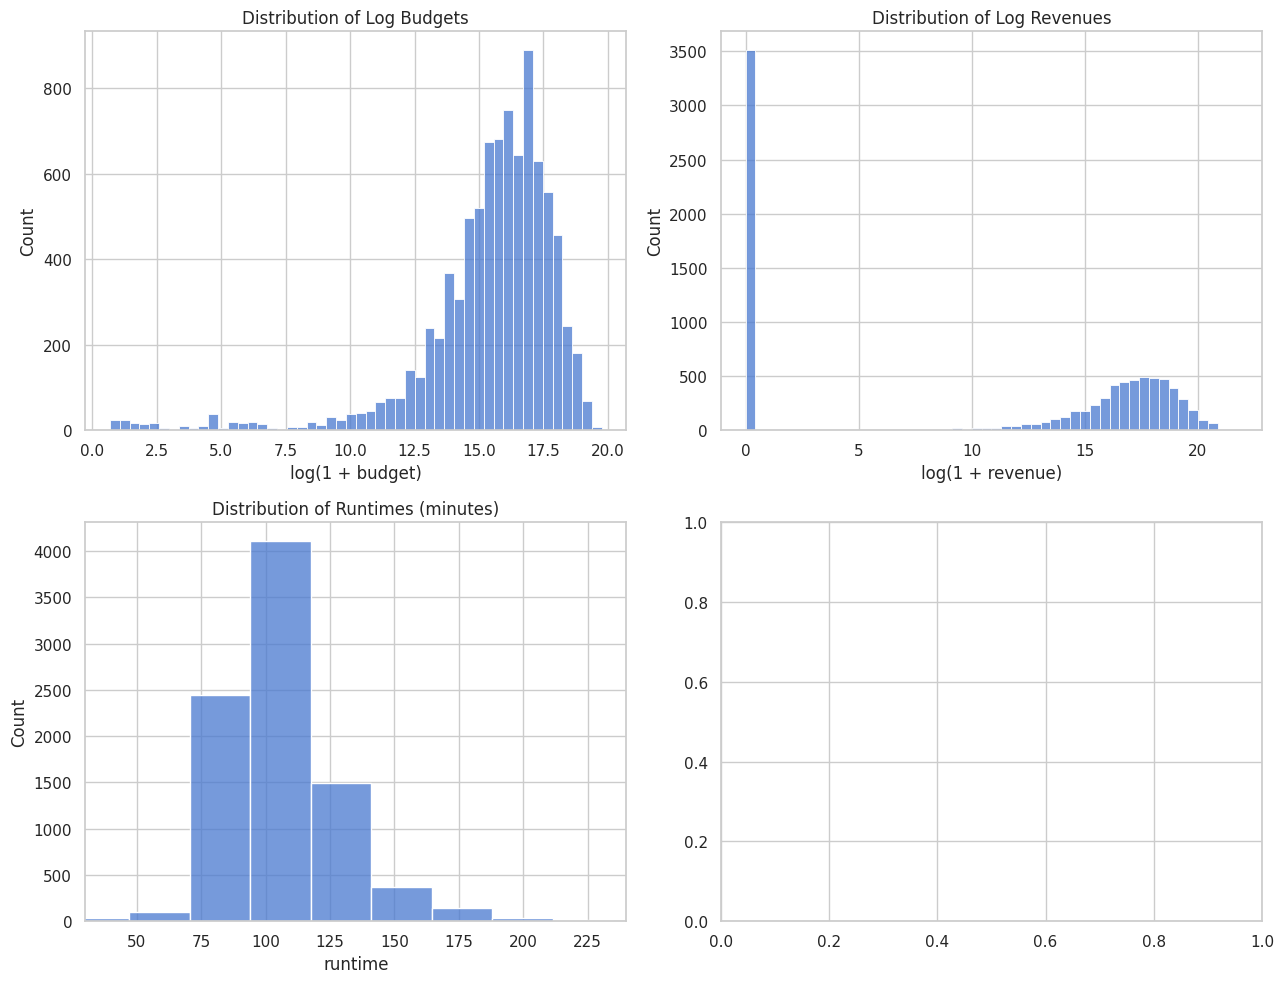

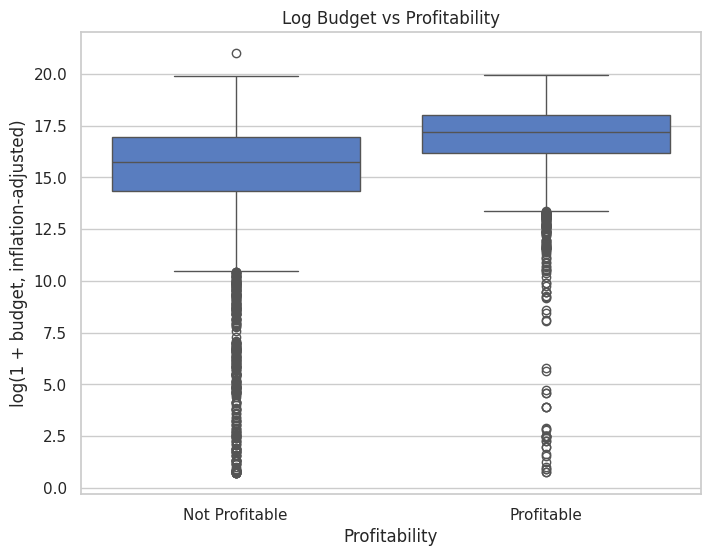

/tmp/ipython-input-1976599895.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="muted")


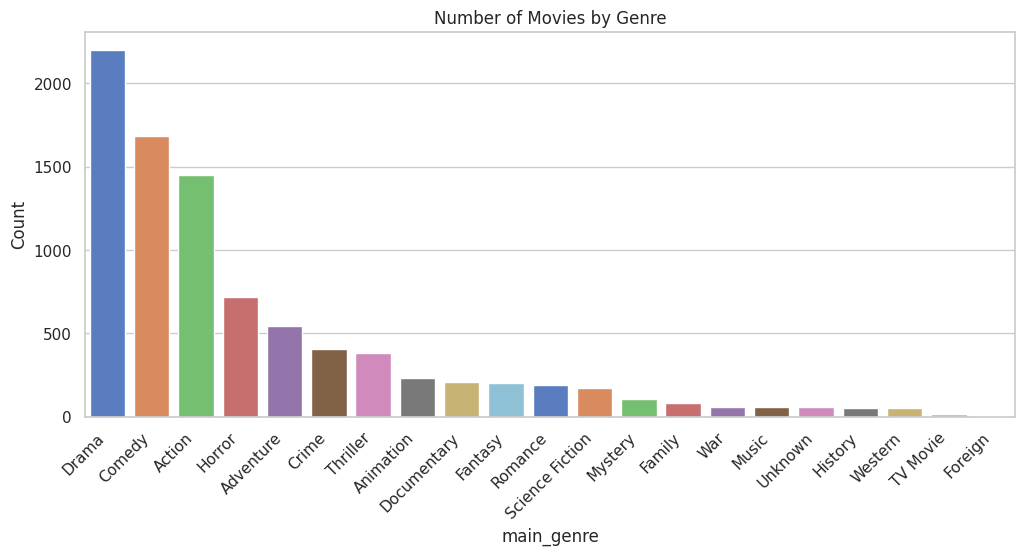


Movies per genre:
 main_genre
Drama          2200
Comedy         1684
Action         1450
Horror          719
Adventure       546
Crime           406
Thriller        381
Animation       233
Documentary     209
Fantasy         204
Name: count, dtype: int64


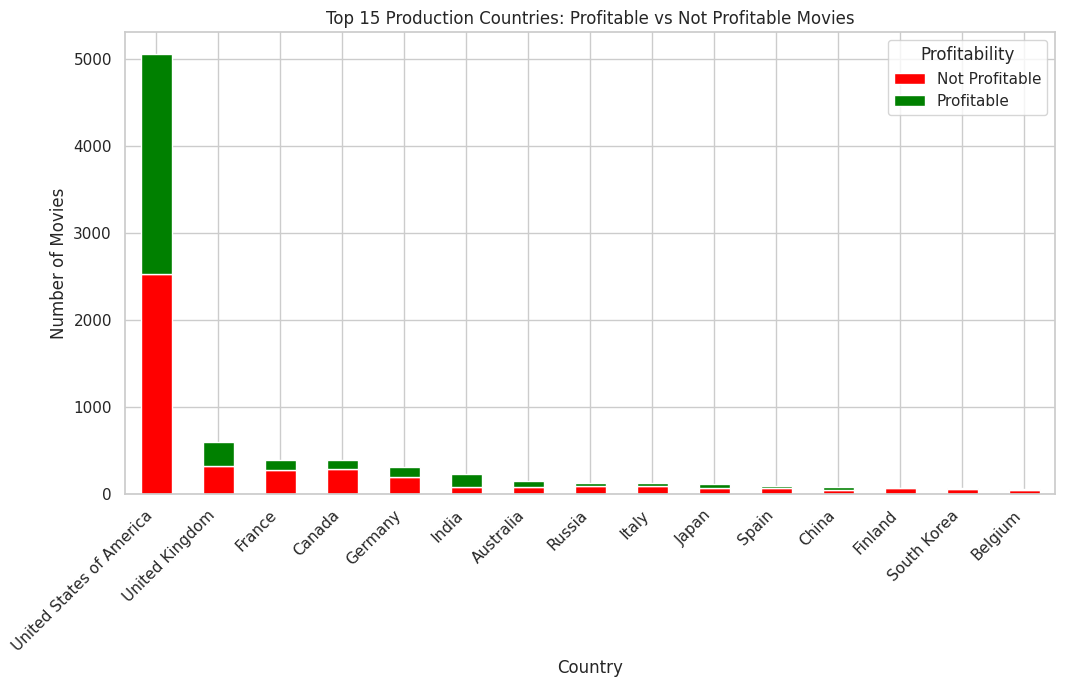

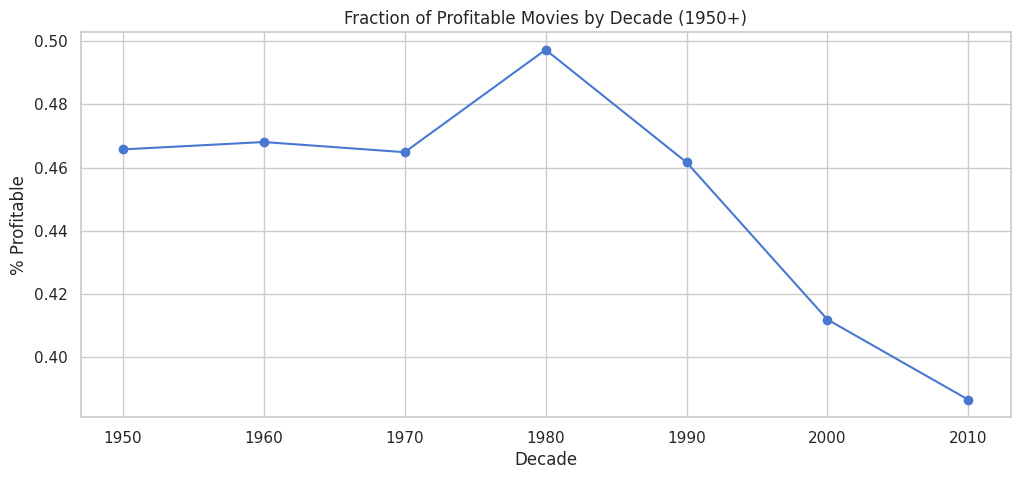

/tmp/ipython-input-1976599895.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=profit_by_genre.index, y=profit_by_genre.values, palette="muted")


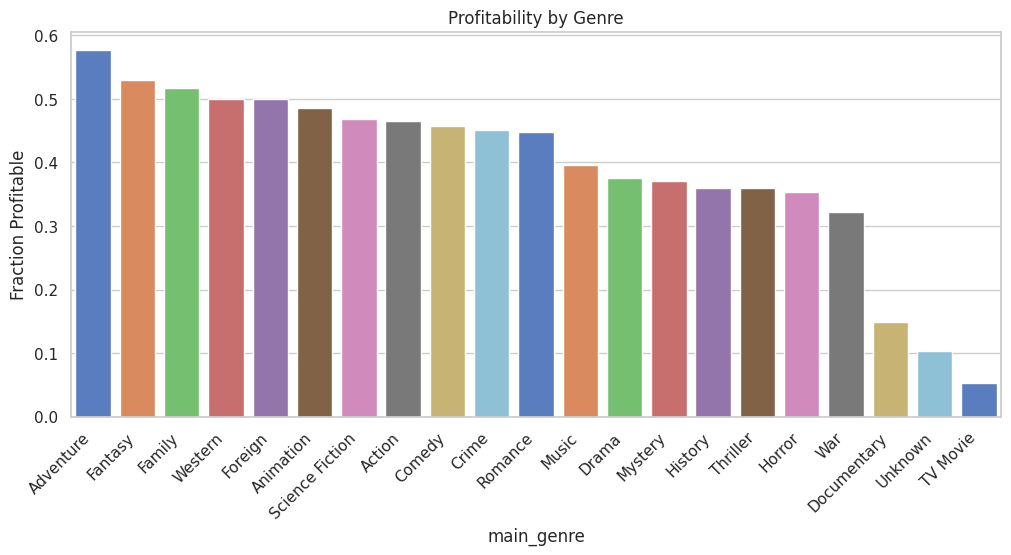

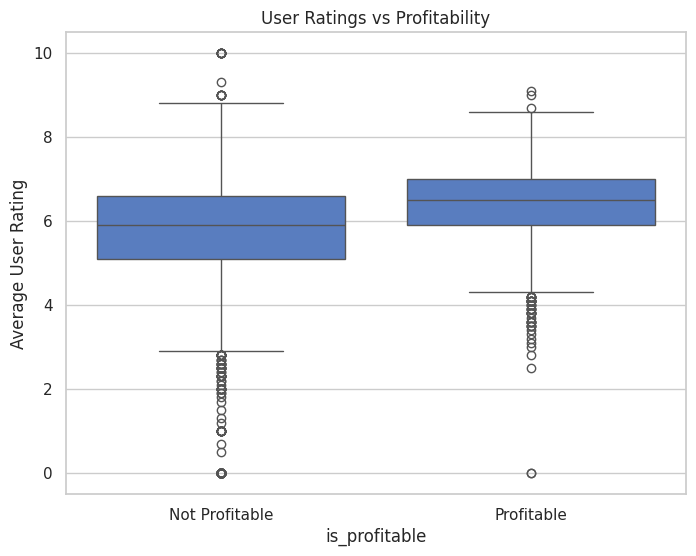

/tmp/ipython-input-1976599895.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="runtime_bucket", y="is_profitable", data=movies, order=labels, palette="muted")


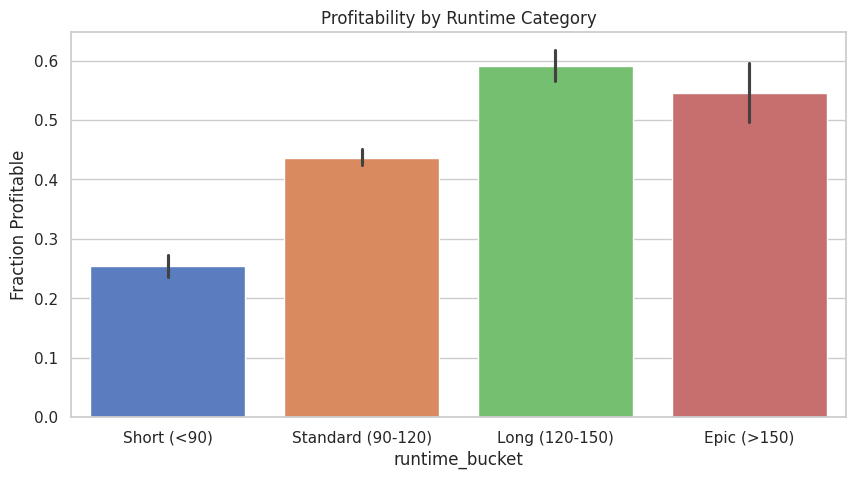

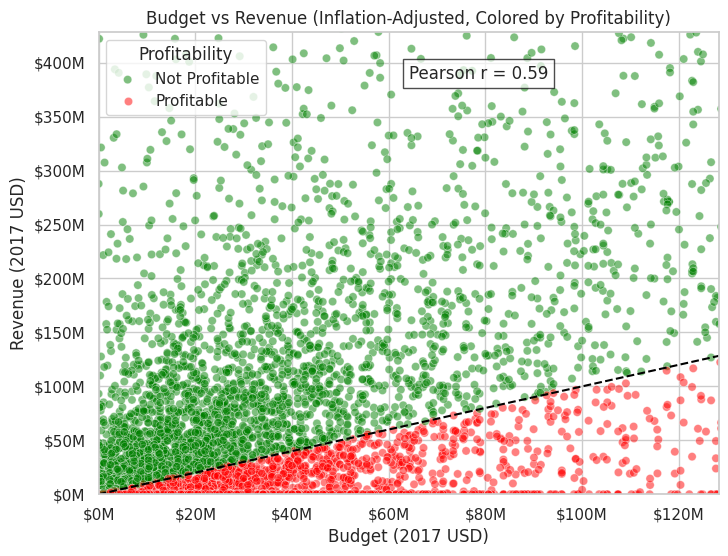

In [16]:
#Exploratory Data Analysis

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="muted")


# 1) Distributions of numeric features
fig, axes = plt.subplots(2,2, figsize=(13,10))

sns.histplot(movies["log_budget"], bins=50, ax=axes[0,0])
axes[0,0].set_title("Distribution of Log Budgets")
axes[0,0].set_xlabel("log(1 + budget)")

sns.histplot(movies["log_revenue"], bins=50, ax=axes[0,1])
axes[0,1].set_title("Distribution of Log Revenues")
axes[0,1].set_xlabel("log(1 + revenue)")

sns.histplot(movies["runtime"], bins=30, ax=axes[1,0])
axes[1,0].set_title("Distribution of Runtimes (minutes)")
axes[1,0].set_xlim(30, 240)   # Trim outliers


plt.tight_layout()
plt.show()


#bugdet compared to profitability
plt.figure(figsize=(8,6))
sns.boxplot(x="is_profitable", y="log_budget_adj", data=movies)
plt.title("Log Budget vs Profitability")
plt.xticks([0,1], ["Not Profitable", "Profitable"])
plt.ylabel("log(1 + budget, inflation-adjusted)")
plt.xlabel("Profitability")
plt.show()

# 2) Dataset composition: genres, languages, countries

# Genre distribution
genre_counts = movies["main_genre"].value_counts().sort_values(ascending=False)
plt.figure(figsize=(12,5))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="muted")
plt.title("Number of Movies by Genre")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.show()
print("\nMovies per genre:\n", genre_counts.head(10))

# Country distribution (main production country, % profitable)
def get_first_country(cell):
    try:
        lst = eval(cell) if isinstance(cell, str) and cell.startswith("[") else []
        if isinstance(lst, list) and len(lst) > 0 and isinstance(lst[0], dict):
            return lst[0]["name"]
    except:
        return None
    return None

movies["main_country"] = movies["production_countries"].apply(get_first_country)

# Country distribution (stacked: profitable vs not profitable counts, top 15 countries)
def get_first_country(cell):
    try:
        lst = eval(cell) if isinstance(cell, str) and cell.startswith("[") else []
        if isinstance(lst, list) and len(lst) > 0 and isinstance(lst[0], dict):
            return lst[0]["name"]
    except:
        return None
    return None

movies["main_country"] = movies["production_countries"].apply(get_first_country)

# Count profitable vs not-profitable movies per country
country_split = (
    movies.groupby(["main_country", "is_profitable"])
    .size()
    .unstack(fill_value=0)
)

# Keep top 15 countries by total count
top_countries = country_split.sum(axis=1).sort_values(ascending=False).head(15)
country_split = country_split.loc[top_countries.index]

# Plot stacked bar chart
country_split.plot(
    kind="bar",
    stacked=True,
    figsize=(12,6),
    color={False: "red", True: "green"}
)

plt.title("Top 15 Production Countries: Profitable vs Not Profitable Movies")
plt.ylabel("Number of Movies")
plt.xlabel("Country")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Profitability", labels=["Not Profitable", "Profitable"])
plt.show()


# --------------------------------------------------
# 3) Profitability over time (by decade, 1940+)
# --------------------------------------------------
movies["release_year"] = pd.to_datetime(movies["release_date"], errors="coerce").dt.year
movies["decade"] = (movies["release_year"] // 10 * 10).astype("Int64")

profit_by_decade = (
    movies[movies["release_year"] >= 1950]
    .groupby("decade")["is_profitable"]
    .mean()
)

plt.figure(figsize=(12,5))
profit_by_decade.plot(marker="o")
plt.title("Fraction of Profitable Movies by Decade (1950+)")
plt.ylabel("% Profitable")
plt.xlabel("Decade")
plt.show()

# 4) Profitability by genre
profit_by_genre = (
    movies.groupby("main_genre")["is_profitable"].mean().sort_values(ascending=False)
)
plt.figure(figsize=(12,5))
sns.barplot(x=profit_by_genre.index, y=profit_by_genre.values, palette="muted")
plt.title("Profitability by Genre")
plt.ylabel("Fraction Profitable")
plt.xticks(rotation=45, ha="right")
plt.show()

# Distribution of average ratings
sns.histplot(movies["vote_average"], bins=20, ax=axes[1,1])
axes[1,1].set_title("Distribution of User Ratings")
axes[1,1].set_xlabel("Average User Rating")

# Ratings vs profitability
plt.figure(figsize=(8,6))
sns.boxplot(x="is_profitable", y="vote_average", data=movies)
plt.title("User Ratings vs Profitability")
plt.xticks([0,1], ["Not Profitable", "Profitable"])
plt.ylabel("Average User Rating")
plt.show()

# Runtime vs profitability
bins = [0, 90, 120, 150, 1000]
labels = ["Short (<90)", "Standard (90-120)", "Long (120-150)", "Epic (>150)"]
movies["runtime_bucket"] = pd.cut(movies["runtime"], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(10,5))
sns.barplot(x="runtime_bucket", y="is_profitable", data=movies, order=labels, palette="muted")
plt.title("Profitability by Runtime Category")
plt.ylabel("Fraction Profitable")
plt.show()

import matplotlib.ticker as ticker

from scipy.stats import pearsonr

# Correlation coefficient
corr, _ = pearsonr(movies["budget_adj"].fillna(0), movies["revenue_adj"].fillna(0))

plt.figure(figsize=(8,6))
sns.scatterplot(
    x="budget_adj", y="revenue_adj",
    data=movies, hue="is_profitable",
    alpha=0.5, palette={0: "red", 1: "green"}
)

# Break-even line
max_val = max(movies["budget_adj"].max(), movies["revenue_adj"].max())
plt.plot([0, max_val], [0, max_val], ls="--", c="black", label="Break-even")

plt.title("Budget vs Revenue (Inflation-Adjusted, Colored by Profitability)")
plt.xlabel("Budget (2017 USD)")
plt.ylabel("Revenue (2017 USD)")
plt.legend(title="Profitability", labels=["Not Profitable", "Profitable"])

# Trim outliers
plt.xlim(0, movies["budget_adj"].quantile(0.95))
plt.ylim(0, movies["revenue_adj"].quantile(0.95))

# Formatting axis
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"${int(x/1e6)}M"))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"${int(y/1e6)}M"))

# Annotate correlation coefficient
plt.text(
    0.5 * movies["budget_adj"].quantile(0.95),
    0.9 * movies["revenue_adj"].quantile(0.95),
    f"Pearson r = {corr:.2f}",
    fontsize=12, bbox=dict(facecolor="white", alpha=0.7, edgecolor="black")
)

plt.show()












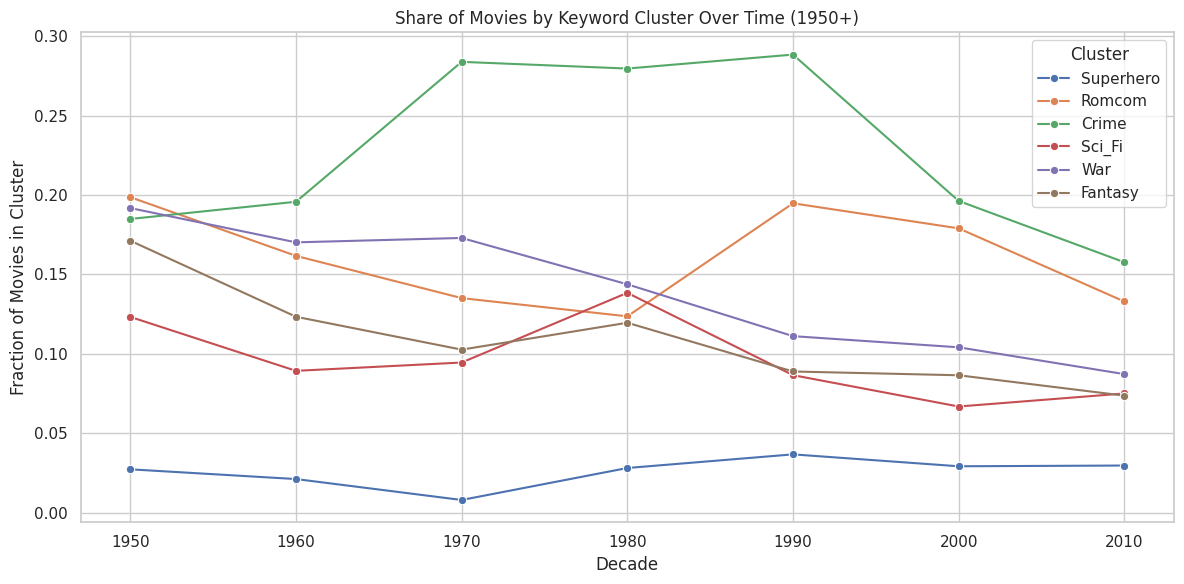

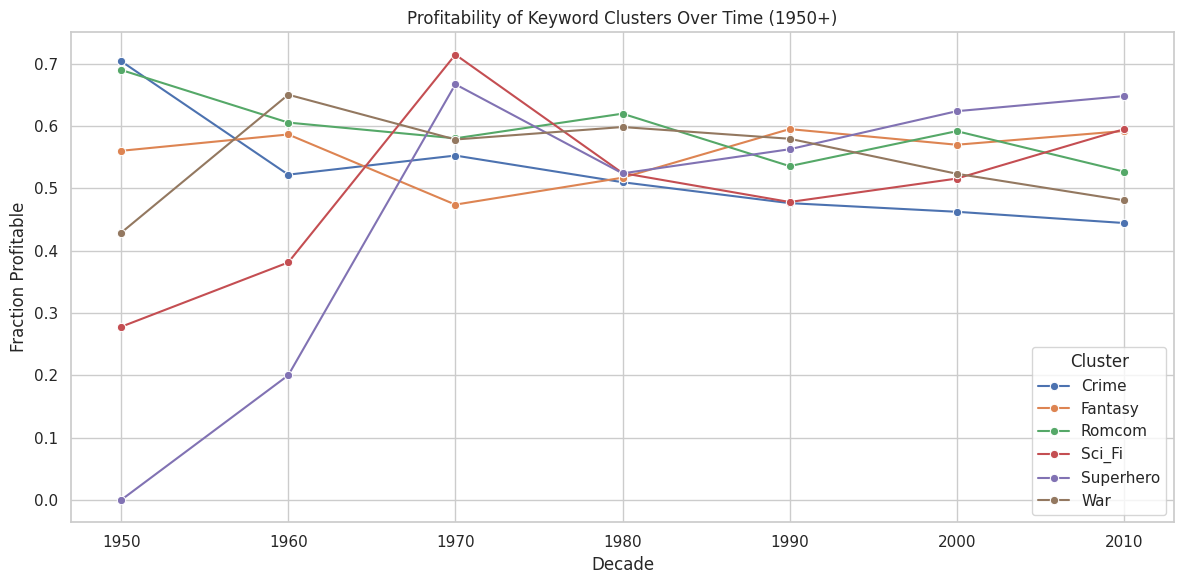

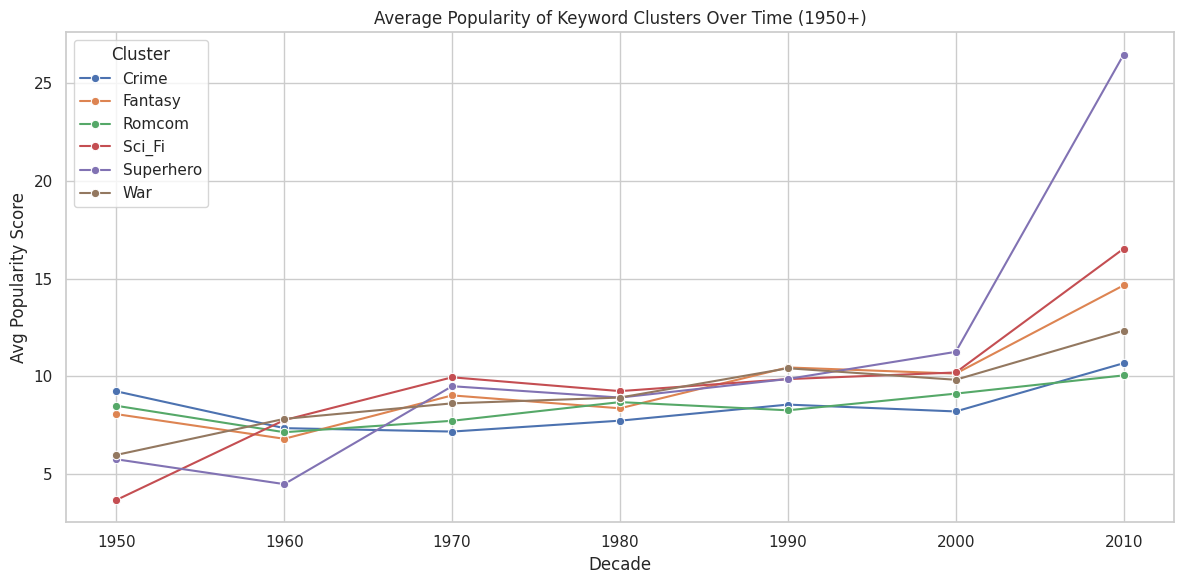

In [18]:
# STEP 4 — Keyword Clusters Over Time (share, profitability, popularity)

import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 0) make sure labels are unique
movies = movies.loc[:, ~movies.columns.duplicated()].copy()

# 1) required columns and types
if "id_num" not in movies.columns:
    movies["id_num"] = pd.to_numeric(movies.get("id"), errors="coerce")
if "release_year" not in movies.columns:
    movies["release_year"] = pd.to_datetime(movies.get("release_date"), errors="coerce").dt.year

# popularity & is_profitable must be numeric for means
movies["popularity"]    = pd.to_numeric(movies.get("popularity"), errors="coerce")
movies["is_profitable"] = pd.to_numeric(movies.get("is_profitable"), errors="coerce")  # 0/1 already, but safe

kw_df = movies[["id_num", "release_year", "is_profitable", "popularity"]].copy()

# 2) ensure kw_list exists, fallback: parse a raw 'keywords' string if available
def _parse_kw(cell):
    try:
        arr = ast.literal_eval(cell)
        if isinstance(arr, list):
            return [(d.get("name","") or "").strip().lower() for d in arr if isinstance(d, dict)]
    except Exception:
        pass
    return []

if "kw_list" in movies.columns:
    kw_df["kw_list"] = movies["kw_list"]
elif "keywords" in movies.columns:
    kw_df["kw_list"] = movies["keywords"].apply(_parse_kw)
else:
    kw_df["kw_list"] = [[] for _ in range(len(kw_df))]

# 3) keyword clusters
keyword_clusters = {
    "superhero": ["superhero","comic book","marvel","dc comics","avenger","justice league","x-men",
                  "batman","superman","spider-man","iron man","captain america","thor","hulk",
                  "black panther","wonder woman","flash","aquaman","deadpool"],
    "romcom":    ["romantic comedy","romance","love","relationship","wedding","dating","bride",
                  "marriage","valentine","kiss","affair","honeymoon","breakup","couple","first love"],
    "crime":     ["crime","criminal","gangster","mafia","heist","robbery","detective","police",
                  "cop","lawyer","noir","serial killer","murder","drug","cartel","prison",
                  "mob","investigation","thriller"],
    "sci_fi":    ["sci-fi","science fiction","space","spaceship","future","futuristic","alien",
                  "extraterrestrial","robot","cyborg","android","time travel","parallel universe",
                  "artificial intelligence","post-apocalyptic","dystopia","nuclear","genetic",
                  "experiment","outer space","galaxy","ufo"],
    "war":       ["war","world war","soldier","battle","army","military","navy","air force",
                  "vietnam","korea","iraq","afghanistan","civil war","ww1","ww2","invasion",
                  "resistance","combat","weapon","nazi"],
    "fantasy":   ["fantasy","magic","magical","dragon","wizard","witch","sorcerer","sorcery",
                  "spell","potion","mythology","myth","legend","sword","elf","orc","troll",
                  "giant","fairy","castle","kingdom","middle earth","chronicles","epic",
                  "creature","beast","dark lord"]
}

def _has_any(kws, words):
    return any(any(w in kw for w in words) for kw in kws)

for cluster, words in keyword_clusters.items():
    kw_df[f"is_{cluster}"] = kw_df["kw_list"].apply(lambda kws: _has_any(kws, words)).astype("uint8")

# 4) numeric coercions before groupby (prevents TypeError in mean)
kw_df["release_year"]  = pd.to_numeric(kw_df["release_year"], errors="coerce")
kw_df["popularity"]    = pd.to_numeric(kw_df["popularity"], errors="coerce")
kw_df["is_profitable"] = pd.to_numeric(kw_df["is_profitable"], errors="coerce")

# 5) decade filtering (1940+)
kw_df = kw_df.dropna(subset=["release_year"]).copy()
kw_df = kw_df[kw_df["release_year"] >= 1950].copy()
kw_df["decade"] = (kw_df["release_year"] // 10 * 10).astype("Int64")

# 6) share of movies in each cluster
cluster_cols = [f"is_{name}" for name in keyword_clusters.keys() if f"is_{name}" in kw_df.columns]
share_by_decade = (
    kw_df.groupby("decade", dropna=True)[cluster_cols]
         .mean()
         .reset_index()
)

# 7) profitability by cluster (use only rows with known target)
profit_curves = []
sub = kw_df.dropna(subset=["is_profitable"])
for c in cluster_cols:
    tmp = (sub[sub[c] == 1]
           .groupby("decade", dropna=True)["is_profitable"]
           .mean()
           .reset_index())
    tmp["cluster"] = c.replace("is_", "")
    profit_curves.append(tmp)
profit_by_decade = pd.concat(profit_curves, ignore_index=True) if profit_curves else pd.DataFrame()

# 8) popularity by cluster
popularity_curves = []
for c in cluster_cols:
    tmp = (kw_df[kw_df[c] == 1]
           .groupby("decade", dropna=True)["popularity"]
           .mean()
           .reset_index())
    tmp["cluster"] = c.replace("is_", "")
    popularity_curves.append(tmp)
popularity_by_decade = pd.concat(popularity_curves, ignore_index=True) if popularity_curves else pd.DataFrame()

# ---------------- Plots ----------------
# 1) Fraction of movies per cluster by decade
plt.figure(figsize=(12,6))
for c in cluster_cols:
    sns.lineplot(x="decade", y=c, data=share_by_decade, marker="o", label=c.replace("is_","").title())
plt.title("Share of Movies by Keyword Cluster Over Time (1950+)")
plt.ylabel("Fraction of Movies in Cluster")
plt.xlabel("Decade")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# 2) Profitability of clusters by decade
if not profit_by_decade.empty:
    plt.figure(figsize=(12,6))
    for name, grp in profit_by_decade.groupby("cluster"):
        sns.lineplot(x="decade", y="is_profitable", data=grp, marker="o", label=name.title())
    plt.title("Profitability of Keyword Clusters Over Time (1950+)")
    plt.ylabel("Fraction Profitable")
    plt.xlabel("Decade")
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()

# 3) Popularity of clusters by decade
if not popularity_by_decade.empty:
    plt.figure(figsize=(12,6))
    for name, grp in popularity_by_decade.groupby("cluster"):
        sns.lineplot(x="decade", y="popularity", data=grp, marker="o", label=name.title())
    plt.title("Average Popularity of Keyword Clusters Over Time (1950+)")
    plt.ylabel("Avg Popularity Score")
    plt.xlabel("Decade")
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()



In [ ]:
# STEP 5 — Feature engineering
import numpy as np
import pandas as pd
import ast

# ---------- 5A. ADJUST BUDGET/REVENUE FOR INFLATION ----------
BASE_YEAR = 2020
ANNUAL_RATE = 0.03

# Ensure release_year exists
if "release_year" not in movies.columns:
    movies["release_year"] = pd.to_datetime(movies.get("release_date"), errors="coerce").dt.year

yr = movies["release_year"].astype("Float64")
factor = np.power(1.0 + ANNUAL_RATE, BASE_YEAR - yr)
factor = factor.fillna(1.0)

movies["budget_adj"]  = movies["budget"]  * factor
movies["revenue_adj"] = movies["revenue"] * factor

# Logs after adjustment
movies["log_budget_adj"]  = np.log1p(movies["budget_adj"])
movies["log_revenue_adj"] = np.log1p(movies["revenue_adj"])

# Main genre
def _parse_first_genre(cell):
    try:
        arr = ast.literal_eval(cell)
        return arr[0]["name"] if isinstance(arr, list) and arr else "Unknown"
    except Exception:
        return "Unknown"

if "main_genre" not in movies.columns:
    if "genres" in movies.columns:
        movies["main_genre"] = movies["genres"].apply(_parse_first_genre)
    else:
        movies["main_genre"] = "Unknown"

# Keyword cluster flags
def _parse_keywords(cell):
    try:
        arr = ast.literal_eval(cell)
        if isinstance(arr, list):
            return [(d.get("name","") or "").strip().lower() for d in arr if isinstance(d, dict)]
    except Exception:
        pass
    return []

if "kw_list" not in movies.columns:
    if "keywords" in movies.columns:
        movies["kw_list"] = movies["keywords"].apply(_parse_keywords)
    else:
        movies["kw_list"] = [[] for _ in range(len(movies))]

keyword_clusters = {
    "superhero": ["superhero","comic book","marvel","dc comics","avenger","justice league","x-men",
                  "batman","superman","spider-man","iron man","captain america","thor","hulk",
                  "black panther","wonder woman","flash","aquaman","deadpool"],
    "romcom":    ["romantic comedy","romance","love","relationship","wedding","dating","bride",
                  "marriage","valentine","kiss","affair","honeymoon","breakup","couple","first love"],
    "crime":     ["crime","criminal","gangster","mafia","heist","robbery","detective","police",
                  "cop","lawyer","noir","serial killer","murder","drug","cartel","prison",
                  "mob","investigation","thriller"],
    "sci_fi":    ["sci-fi","science fiction","space","spaceship","future","futuristic","alien",
                  "extraterrestrial","robot","cyborg","android","time travel","parallel universe",
                  "artificial intelligence","post-apocalyptic","dystopia","nuclear","genetic",
                  "experiment","outer space","galaxy","ufo"],
    "war":       ["war","world war","soldier","battle","army","military","navy","air force",
                  "vietnam","korea","iraq","afghanistan","civil war","ww1","ww2","invasion",
                  "resistance","combat","weapon","nazi"],
    "fantasy":   ["fantasy","magic","magical","dragon","wizard","witch","sorcerer","sorcery",
                  "spell","potion","mythology","myth","legend","sword","elf","orc","troll",
                  "giant","fairy","castle","kingdom","middle earth","chronicles","epic",
                  "creature","beast","dark lord"]
}

def _has_any_cluster_word(kws, words):
    return any(any(w in kw for w in words) for kw in kws)

for cluster, words in keyword_clusters.items():
    movies[f"is_{cluster}"] = movies["kw_list"].apply(
        lambda kws: _has_any_cluster_word(kws, words)
    ).astype(np.uint8)

# added runtime flags to try see if there is a sweet spot or range
movies["is_short"]  = (movies["runtime"] < 80).astype(np.uint8)
movies["is_medium"] = ((movies["runtime"] >= 80) & (movies["runtime"] <= 140)).astype(np.uint8)
movies["is_long"]   = (movies["runtime"] > 140).astype(np.uint8)

#features
base_features = ["log_budget_adj", "runtime", "vote_average", "vote_count", "popularity"]
base_features = [c for c in base_features if c in movies.columns]

cluster_flags = [f"is_{c}" for c in keyword_clusters.keys() if f"is_{c}" in movies.columns]
runtime_flags = ["is_short","is_medium","is_long"]

features = base_features + cluster_flags + runtime_flags + ["main_genre"]

X = movies[features]
y = movies["is_profitable"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print("Feature matrix shape:", X.shape)
print("Example columns:", X.columns[:15].tolist())



In [22]:
import numpy as np
import pandas as pd


# Numeric features → will be standardized (mean=0, std=1).
numeric_features = ["log_budget_adj", "runtime", "vote_average", "vote_count", "popularity"]
numeric_features = [c for c in numeric_features if c in movies.columns]  # ensure they exist

# Categorical feature → main_genre is still a string ("Action", "Comedy", etc.),
# so we will one-hot encode it (turn into dummy columns).
categorical_features = ["main_genre"]
categorical_features = [c for c in categorical_features if c in movies.columns]  # ensure it exists

# Keyword cluster flags (e.g. is_superhero, is_romcom, ...) and runtime flags, alr binary
runtime_flags = ["is_short", "is_medium", "is_long"]
runtime_flags = [c for c in runtime_flags if c in movies.columns]

# EXCLUDE runtime flags (and target) from kw_flags so we don't double select them
kw_flags = [
    c for c in movies.columns
    if c.startswith("is_") and c not in (["is_profitable"] + runtime_flags)
]

# 🔧 Cast flags to plain int so imputers don't choke on uint8
for _c in kw_flags + runtime_flags:
    if _c in movies.columns:
        movies[_c] = movies[_c].astype(int)

# Build a unique ordered list of all flags (prevents duplicate column selection)
def _unique_in_order(seq):
    seen = set()
    out = []
    for x in seq:
        if x not in seen:
            out.append(x)
            seen.add(x)
    return out

all_flags = _unique_in_order(kw_flags + runtime_flags)

# Scale numeric columns → prevents large numbers (like vote_count) from dominating
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),   # fill numeric NaNs
    ("scaler",  StandardScaler())
])

# One-hot encode genres → robust to new/unknown categories
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # fill missing strings
    ("ohe",     OneHotEncoder(handle_unknown="ignore"))
])

# ColumnTransformer → combines different preprocessing steps
# (scale numbers, encode genres, pass through flags).
preprocessor = ColumnTransformer(
    transformers=[
        ("num",  numeric_transformer, numeric_features),          #numerical values
        ("cat",  categorical_transformer, categorical_features),  #categorical values
        ("flags", SimpleImputer(strategy="constant", fill_value=0), all_flags),  #flags (deduped)
    ],
    remainder="drop"  # ignore anything not listed
)

# Build modeling frame & split
model_cols = numeric_features + categorical_features + all_flags + ["is_profitable"]
model_df = movies[model_cols].dropna(subset=["is_profitable"]).copy()
X = model_df.drop(columns=["is_profitable"])
y = model_df["is_profitable"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Log regress.
log_reg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

# Train model
log_reg.fit(X_train, y_train)

# Evaluate on the test set
print("Logistic Regression Results")
print(classification_report(y_test, log_reg.predict(X_test)))
print("ROC-AUC:", roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1]))
#  Precision of the movies predicted profitable, how many actually were
# Recall, of the profitable movies, how many did we catch F1: prec+reclass
# ROC-AUC: how well the model separates profitable vs not across thresholds

# Random Forest is more flexible than logistic regression builds many decision trees and averages them.
rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train
rf.fit(X_train, y_train)

# Evaluate performance
print("\nRandom Forest Results")
print(classification_report(y_test, rf.predict(X_test)))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))

#feature importance
from sklearn.utils.validation import check_is_fitted
import pandas as pd

# --- Logistic Regression coefficients ---
check_is_fitted(log_reg)  # make sure pipeline is fitted

log_features = log_reg.named_steps['preprocessor'].get_feature_names_out()
log_clf = log_reg.named_steps['classifier']
log_coefs = log_clf.coef_[0]

coef_df = pd.DataFrame({
    "feature": log_features,
    "coefficient": log_coefs
}).sort_values("coefficient", ascending=False)

print("\n=== Logistic Regression Coefficients ===")
print("\nTop positive coefficients (push toward PROFIT):")
print(coef_df.head(10).to_string(index=False))

print("\nTop negative coefficients (push toward NON-PROFIT):")
print(coef_df.tail(10).to_string(index=False))


# --- Random Forest feature importances ---
check_is_fitted(rf)  # make sure pipeline is fitted

rf_features = rf.named_steps['preprocessor'].get_feature_names_out()
rf_clf = rf.named_steps['classifier']
rf_importances = rf_clf.feature_importances_

imp_df = pd.DataFrame({
    "feature": rf_features,
    "importance": rf_importances
}).sort_values("importance", ascending=False)

print("\n=== Random Forest Feature Importances ===")
print(imp_df.head(15).to_string(index=False))



Logistic Regression Results
              precision    recall  f1-score   support

           0       0.75      0.89      0.81      1027
           1       0.80      0.59      0.68       751

    accuracy                           0.77      1778
   macro avg       0.77      0.74      0.75      1778
weighted avg       0.77      0.77      0.76      1778

ROC-AUC: 0.842811337560954

Random Forest Results
              precision    recall  f1-score   support

           0       0.77      0.85      0.81      1027
           1       0.77      0.66      0.71       751

    accuracy                           0.77      1778
   macro avg       0.77      0.76      0.76      1778
weighted avg       0.77      0.77      0.77      1778

ROC-AUC: 0.8486756379355278

=== Logistic Regression Coefficients ===

Top positive coefficients (push toward PROFIT):
                feature  coefficient
        num__vote_count     3.041278
cat__main_genre_Foreign     1.069722
        num__popularity     0.564239
 

In [24]:
# Studio 300 mil tests - testing movies, assuming 2010 release

# Use dataset averages for unknown audience-side features
avg_vote_count = movies["vote_count"].mean()
avg_vote_average = movies["vote_average"].mean()
avg_popularity = movies["popularity"].mean()

portfolio = pd.DataFrame([
    # 2 high-budget blockbusters
    {"title": "Action Superhero Movie", "release_year": 2010, "budget": 200_000_000, "runtime": 120,
     "main_genre": "Action", "is_superhero": 1, "is_sci_fi": 1,
     "is_romcom": 0, "is_crime": 0, "is_war": 0, "is_fantasy": 0,
     "is_short": 0, "is_medium": 1, "is_long": 0,
     "vote_count": avg_vote_count, "vote_average": avg_vote_average, "popularity": avg_popularity},

    # 2 mid-budget romcoms
    {"title": "Romantic Comedy 1", "release_year": 2010, "budget": 50_000_000, "runtime": 110,
     "main_genre": "Romance", "is_romcom": 1, "is_crime": 0, "is_superhero": 0,
     "is_sci_fi": 0, "is_war": 0, "is_fantasy": 0,
     "is_short": 0, "is_medium": 1, "is_long": 0,
     "vote_count": avg_vote_count, "vote_average": avg_vote_average, "popularity": avg_popularity},

    {"title": "Romantic Comedy 2", "release_year": 2010, "budget": 50_000_000, "runtime": 115,
     "main_genre": "Romance", "is_romcom": 1, "is_crime": 0, "is_superhero": 0,
     "is_sci_fi": 0, "is_war": 0, "is_fantasy": 0,
     "is_short": 0, "is_medium": 1, "is_long": 0,
     "vote_count": avg_vote_count, "vote_average": avg_vote_average, "popularity": avg_popularity},
])

# Adjust for inflation + log
factor = np.power(1.0 + 0.03, 2020 - portfolio["release_year"])
portfolio["budget_adj"] = portfolio["budget"] * factor
portfolio["log_budget_adj"] = np.log1p(portfolio["budget_adj"])

# Predict with both models
print("Predictions for $300M Portfolio:")
for model_name, model in [("LogReg", log_reg), ("RandomForest", rf)]:
    probs = model.predict_proba(portfolio)[:, 1]
    preds = model.predict(portfolio)
    portfolio[f"{model_name}_Prob"] = probs
    portfolio[f"{model_name}_Pred"] = preds

print(portfolio[["title", "budget", "main_genre", "LogReg_Prob", "RandomForest_Prob"]])


Predictions for $300M Portfolio:
                    title     budget main_genre  LogReg_Prob  \
0  Action Superhero Movie  200000000     Action     0.626528   
1       Romantic Comedy 1   50000000    Romance     0.613178   
2       Romantic Comedy 2   50000000    Romance     0.618944   

   RandomForest_Prob  
0               0.64  
1               0.82  
2               0.81  
